In [2]:
import pandas as pd
from pandas import DataFrame

try:
# Carica il tuo file XLSX
    xlsx_file = 'C:/Users/loris/Desktop/Python Workspace/FirstTryMiller/dataset/richerDataset.xlsx'  # Sostituisci con il percorso del tuo file

# Leggi i dati dal file XLSX e crea un DataFrame
    df: DataFrame = pd.read_excel(xlsx_file)

# Ora hai un DataFrame con tutti i dati dal tuo file XLSX che puoi utilizzare per l'analisi.
except FileNotFoundError as e:
    print("Il file non è stato trovato.")
# except Exception as e:
    print(f"Si è verificato un errore: {e}")                                                          
    
# Rimuovi il record con k_m2 uguale a 0
df = df[df['k_m2'] != 0]
#Rimuovi colonne Porosity tot e SSA tot
df = df.drop(['Porosity_Tot', 'SSA_Tot','Ech'], axis=1)
# Resetta gli indici del DataFrame
df.reset_index(drop=True, inplace=True)



k2_max = df['k_m2'].max()
k2_min = df['k_m2'].min()
print(df)



    Conn.Dens.  Porosity     SSA  Tortuosity          k_m2
0      310.913     0.137   5.065      2.0340  1.473350e-12
1      310.913     0.147   5.253      2.6650  2.254724e-12
2      310.913     0.131   4.697      2.1090  9.543177e-12
3      350.137     0.115   5.583      4.1830  9.664920e-13
4      350.137     0.139   7.447      2.5950  9.180783e-13
5      350.137     0.115   5.311      4.1010  1.435774e-12
6      368.141     0.134   6.990      2.7740  4.010302e-13
7      368.141     0.138   7.132      2.7790  3.937021e-12
8      368.141     0.116   5.290      3.8680  1.933907e-12
9       10.573     0.020   0.791      3.1000  3.021802e-13
10      10.573     0.020   0.806      2.9000  3.190436e-13
11     458.436     0.273   7.721      1.7170  5.516051e-11
12     458.436     0.250   6.870      1.3530  3.822390e-11
13     458.436     0.265   7.560      1.5730  5.275967e-11
14     607.796     0.250   7.353      1.3400  2.009570e-11
15     607.796     0.281   8.363      1.3720  1.319490e-

In [3]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df)
# Crea un nuovo DataFrame con i dati scalati e riassegna le colonne non scalate
#df_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

# Stampa il DataFrame scalato
print("DataFrame scalato:")
print(df_scaled)

DataFrame scalato:
    Conn.Dens.  Porosity       SSA  Tortuosity      k_m2
0     0.502894  0.422383  0.449469    0.222507  0.010982
1     0.502894  0.458484  0.469240    0.424816  0.016905
2     0.502894  0.400722  0.410769    0.246553  0.072152
3     0.568572  0.342960  0.503944    0.911510  0.007140
4     0.568572  0.429603  0.699968    0.402373  0.006773
5     0.568572  0.342960  0.475339    0.885220  0.010697
6     0.598718  0.411552  0.651909    0.459763  0.002854
7     0.598718  0.425993  0.666842    0.461366  0.029657
8     0.598718  0.346570  0.473131    0.810516  0.014473
9     0.000000  0.000000  0.000000    0.564283  0.002104
10    0.000000  0.000000  0.001577    0.500160  0.002232
11    0.749909  0.913357  0.728783    0.120872  0.417936
12    0.749909  0.830325  0.639289    0.004168  0.289555
13    0.749909  0.884477  0.711852    0.074703  0.399737
14    1.000000  0.830325  0.690083    0.000000  0.152141
15    1.000000  0.942238  0.796298    0.010260  1.000000
16    1.0000

Best random_state for train_test_split: 80 with R^2 score: 0.9973094660282624


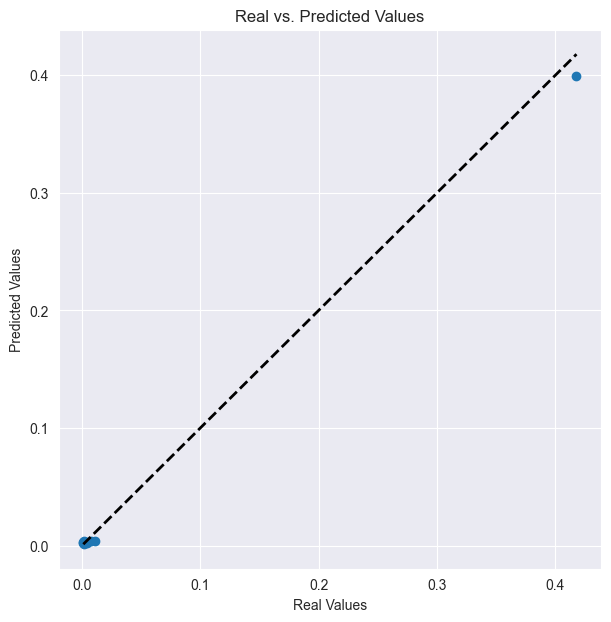

In [4]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


best_y_pred = None
best_y_test = None
best_random_state_split = None
best_score_split = -float('inf')

for random_state in range(0, 100):
    X = df_scaled.drop('k_m2', axis=1)
    y = df_scaled['k_m2']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    model = XGBRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    
    if score > best_score_split:
        best_score_split = score
        best_random_state_split = random_state
        best_y_pred = y_pred
        best_y_test = y_test

print(f"Best random_state for train_test_split: {best_random_state_split} with R^2 score: {best_score_split}")

plt.figure(figsize=(7, 7))
plt.scatter(best_y_test, best_y_pred)
plt.plot([best_y_test.min(), best_y_test.max()], [best_y_test.min(), best_y_test.max()], 'k--', lw=2)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs. Predicted Values')
plt.grid(True)
plt.show()

In [6]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import logging
from tqdm.notebook import tqdm
import joblib


param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1,0.3],
    'max_depth': [3, 5, 9, 15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 5]
}

X = df_scaled.drop('k_m2', axis=1)
y = df_scaled['k_m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=best_random_state_split)

model = XGBRegressor(random_state=best_random_state_split)


# Integra tqdm con joblib per mostrare la progress bar
tqdm_callback = lambda iterable: tqdm(
    iterable, 
    total=len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree']), 
    desc="Hyperparameter tuning"
)

# Usa joblib per patchare il parallel computing di scikit-learn
with joblib.parallel_backend('loky', inner_max_num_threads=1):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"R^2 score: {r2_score(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
R^2 score: 0.9778900136100425
MSE: 0.00034169506178880263
MAE: 0.01467142349572954


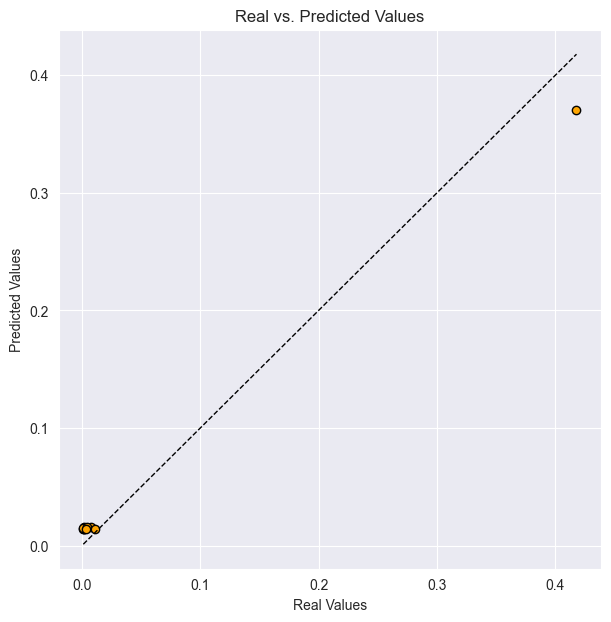

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, color='orange', alpha=0.99, edgecolors='black') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs. Predicted Values')
plt.grid(True)
plt.show()

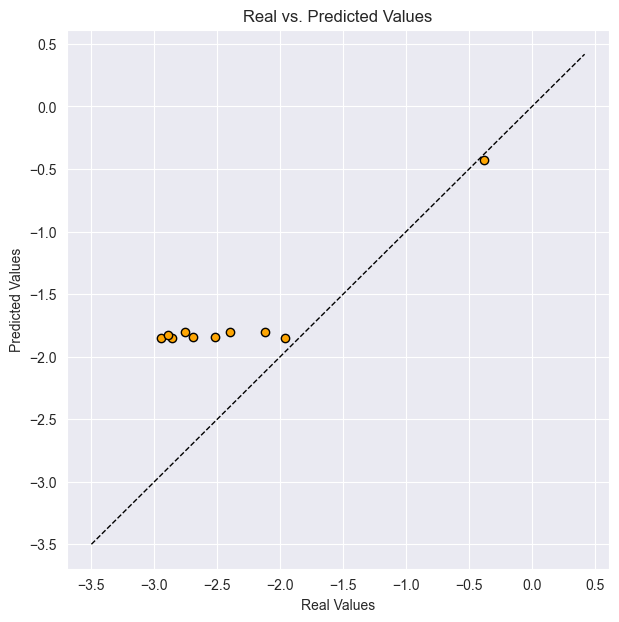

In [8]:
#Visualizzo in Log10

plt.figure(figsize=(7, 7))
plt.scatter(np.log10(y_test), np.log10(y_pred), color='orange', alpha=0.99, edgecolors='black') 
plt.plot([-3.5, y_test.max()], [-3.5, y_test.max()], 'k--', lw=1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs. Predicted Values')
plt.grid(True)
plt.show()

In [9]:
plt.show()
# Crea un DataFrame con i valori reali e predetti
results_df = pd.DataFrame({
    'Valori Reali': y_test,
    'Valori Predetti': y_pred
})

# Stampa il DataFrame
print("\nValori Reali vs Valori Predetti:\n")
print(results_df)


Valori Reali vs Valori Predetti:

    Valori Reali  Valori Predetti
20      0.001381         0.014014
41      0.001757         0.015871
34      0.001132         0.014014
42      0.007556         0.015871
26      0.002038         0.014229
44      0.001272         0.014790
21      0.004007         0.015606
27      0.003040         0.014229
39      0.010879         0.014014
11      0.417936         0.370796
